In [2]:
import os.path
import cv2
import numpy as np
import requests


In [4]:
yolo_config = 'yolov3.cfg'
if not os.path.isfile(yolo_config):
    url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg'
    r = requests.get(url)
    with open(yolo_config, 'wb') as f:
        f.write(r.content)

yolo_weights = 'yolov3.weights'
if not os.path.isfile(yolo_weights):
    url = 'https://pjreddie.com/media/files/yolov3.weights'
    r = requests.get(url)
    with open(yolo_weights, 'wb') as f:
        f.write(r.content)

classes_file = 'coco.names'
if not os.path.isfile(classes_file):
    url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names'
    r = requests.get(url)
    with open(classes_file, 'wb') as f:
        f.write(r.content)

# Load class names
with open(classes_file, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# Download the image
image_url = 'https://thumbs.dreamstime.com/z/people-vehicles-bangkok-city-street-february-king-power-mahanakhon-thailand-moving-142180158.jpg'
image_file = 'street_image.jpg'
r = requests.get(image_url)
with open(image_file, 'wb') as f:
    f.write(r.content)

# Load and normalize the image
image = cv2.imread(image_file)
blob = cv2.dnn.blobFromImage(image, 1 / 255, (416, 416), (0, 0, 0), True, crop=False)


# Load the network
net = cv2.dnn.readNet(yolo_weights, yolo_config)
net.setInput(blob)

# Get network output layers
layer_names = net.getLayerNames()
output_layers = [layer_names[np.squeeze(i) - 1] for i in net.getUnconnectedOutLayers()]


# Inference - The network outputs multiple lists of anchor boxes, one for each detected class
outs = net.forward(output_layers)

# Extract bounding boxes
class_ids = []
confidences = []
boxes = []

# Iterate over all classes
for out in outs:
    # Iterate over the anchor boxes for each class
    for detection in out:
        # Bounding box
        center_x = int(detection[0] * image.shape[1])
        center_y = int(detection[1] * image.shape[0])
        w = int(detection[2] * image.shape[1])
        h = int(detection[3] * image.shape[0])
        x = center_x - w // 2
        y = center_y - h // 2
        boxes.append([x, y, w, h])

        # Class
        class_id = np.argmax(detection[5:])
        class_ids.append(class_id)

        # Confidence
        confidence = detection[4]
        confidences.append(float(confidence))

# Non-max suppression
ids = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.3, nms_threshold=0.5)
# Draw the bounding boxes on the image
colors = np.random.uniform(0, 255, size=(len(classes), 3))

colors = np.random.uniform(0, 255, size=(len(classes), 3))
for idx in ids:
    x, y, w, h = boxes[idx]
    class_id = class_ids[idx]
    color = colors[class_id]
    cv2.rectangle(image, (round(x), round(y)), (round(x + w), round(y + h)), color, 2)
    label = "%s: %.2f" % (classes[class_id], confidences[idx])
    cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

cv2.imshow('YOLO Detection', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

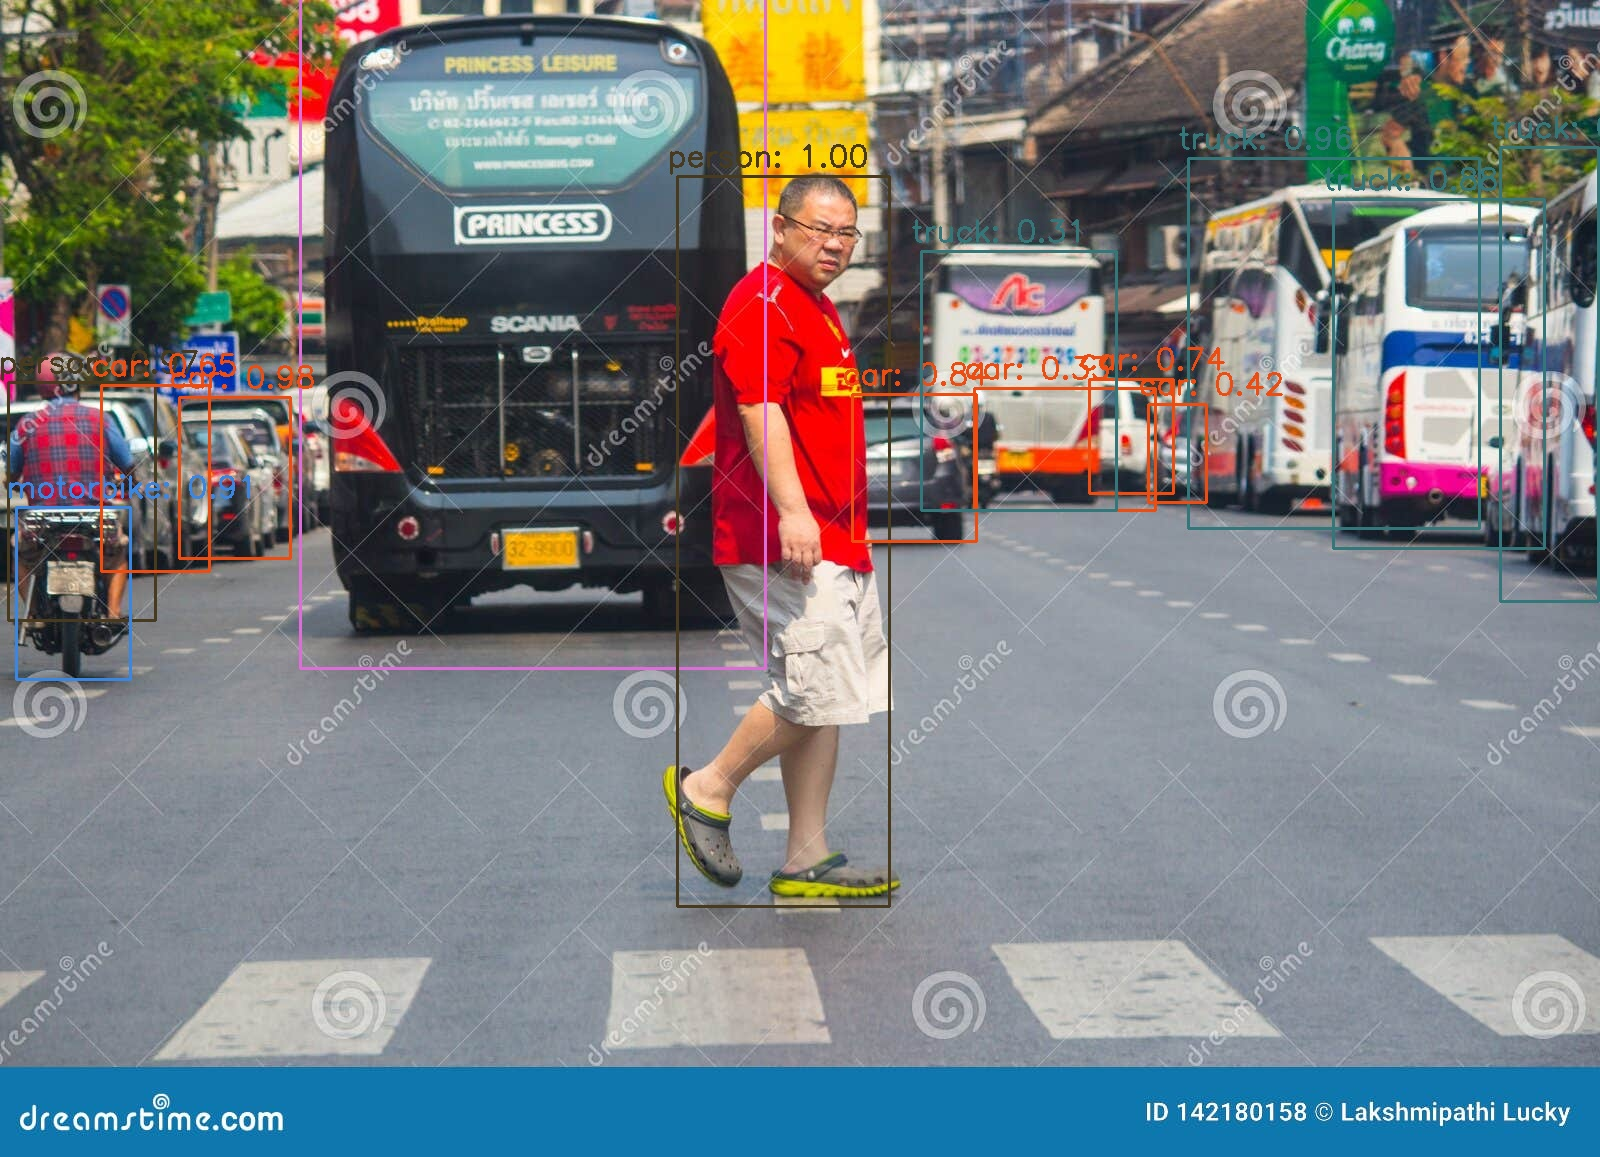

In [6]:
from IPython.display import Image, display
cv2.imwrite('output_image.jpg', image)
display(Image(filename='output_image.jpg'))